 # 2DMD at a Glance

The commands below import the libraries used throughout the Jupyter notebook

In [51]:
import io
import re
import ast
import requests
import zipfile
import tarfile
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import Parallel, delayed
from collections import Counter, OrderedDict
from itertools import chain
from tqdm.notebook import tqdm
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.core import Structure
from pymatgen.core.periodic_table import Element
from sklearn.model_selection import train_test_split

## Functions

Functions for data processing and data preparation in the Pandas DataFrame format

In [22]:
BASES_and_CONCENTRATIONS = [['BP_spin_500', 'high'], ['GaSe_spin_500', 'high'],
                            ['hBN_spin_500', 'high'], ['InSe_spin_500', 'high'],
                            ['MoS2', 'low'], ['MoS2_500', 'high'],
                            ['WSe2', 'low'], ['WSe2_500', 'high']
                           ]


def readStructures(base, concentration, structure_ids):
    
    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:
        
        base_in_zip = f'{concentration}_density_defects/{base}'
        with tarfile.open(
            fileobj=io.BytesIO(datasets_zip.read(f'{base_in_zip}/initial.tar.gz'))
        ) as tf:
            cifs = [tf.extractfile(f'{_id}.cif').read().decode("utf-8") 
                    for _id in tqdm(structure_ids)]

    return pd.DataFrame(cifs, index=structure_ids, columns=['cif'])

def parseStructure(cif_string):

    structure = Structure.from_str(cif_string, fmt='cif') #.get_structures(primitive=False)[0]
    space_group_number = SpacegroupAnalyzer(structure).get_space_group_number()
    lattice = structure.lattice.matrix
    positions = np.array([x.coords for x in structure])
    atomic_symbols = np.array(list(map(lambda x: x.symbol, structure.species)))
    atomic_numbers = np.array(list(map(lambda x: Element(x).number, atomic_symbols)))
    formula = OrderedDict(sorted(Counter(atomic_symbols).items()))
    return [space_group_number, lattice, positions, atomic_symbols, atomic_numbers, formula, 
                         len(atomic_numbers), len(formula)]


def structureFormationEnergy(structure, neat_elements):

    fe = structure['energy']
    formula = structure['formula']
    for element in formula.keys() :
        element_chem_potential = neat_elements.loc[element]['chemical_potential']
        fe -= formula[element] * element_chem_potential
    return fe


def flatList(list_):
    
    return [str(item) for sublist in list_ for item in sublist]


def readDataFromArchive(base, concentration):

    with zipfile.ZipFile('2d-materials-point-defects-all.zip') as datasets_zip:

        base_in_zip = f'{concentration}_density_defects/{base}'

        with datasets_zip.open(f'{base_in_zip}/defects.csv.gz') as defects_gz :
            with gzip.open(defects_gz) as defects_data :
                defects_df = pd.read_csv(defects_data, sep=',')

        with datasets_zip.open(f'{base_in_zip}/descriptors.csv') as descriptors :
            descriptors_df = pd.read_csv(descriptors, sep=',')

        with datasets_zip.open(f'{base_in_zip}/elements.csv') as elements :
            neat_elements_df = pd.read_csv(elements, sep=',')
        neat_elements_df.set_index('element', inplace=True, drop=True)
        print(neat_elements_df)

        with datasets_zip.open(f'{base_in_zip}/initial_structures.csv') as init_structures :
            init_structures_df = pd.read_csv(init_structures, sep=',')

        with datasets_zip.open(f'{base_in_zip}/targets.csv.gz') as targets_gz :
            with gzip.open(targets_gz) as targets_data :
                targets_df = pd.read_csv(targets_data, sep=',')

    return defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df


def handleTableData(base, concentration) :

    defects_df, descriptors_df, neat_elements_df, init_structures_df, targets_df = \
                                                        readDataFromArchive(base, concentration)
    print('\n' + '*'*90 + '\n')
    
    print(f'Information on defects.csv.gz for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in defects_df.columns:
            defects_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', defects_df.columns)
    print('\tshape:', defects_df.shape)
    number_of_unique = len(defects_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(defects_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on descriptors.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in descriptors_df.columns:
            descriptors_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', descriptors_df.columns)
    print('\tshape:', descriptors_df.shape)
    number_of_unique = len(descriptors_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print(f'Information on targets.csv for {base}_{concentration}_concentration')
    for unused_property in ['Unnamed: 0', 'defect_id'] :
        if unused_property in targets_df.columns:
            targets_df.drop(unused_property, axis=1, inplace=True)
    print('\tcolumns:', targets_df.columns)
    print('\tshape:', targets_df.shape)
    number_of_unique = len(targets_df['_id'].unique())
    print(f'\t{number_of_unique} unique defect structures')
    number_of_unique = len(targets_df['descriptor_id'].unique())
    print(f'\t{number_of_unique} unique defect descriptors')

    print('\n' + '*'*90 + '\n')
    print('Data checking...')
    print(f'Is \'descriptor_id\'s (defects.csv) a subset of \'_id\'s (descriptors.csv)?', 
          set(defects_df['descriptor_id']).issubset(set(descriptors_df['_id'])))

    defects_df.set_index('_id', inplace=True, drop=True)
    targets_df.set_index('_id', inplace=True, drop=True)
    descriptors_df.set_index('_id', inplace=True, drop=True)        

    data = pd.DataFrame(descriptors_df.loc[defects_df['descriptor_id']].values, 
                                    columns=descriptors_df.columns, index=defects_df.index)

    for additional_data in [defects_df, targets_df] :
        for piece_of_data in additional_data.columns :
            if (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype != 'O') :
                diff = additional_data[piece_of_data] - data[piece_of_data]
                out_ = np.abs(diff).max()
                print(f'{piece_of_data:>21s} is in the data with the maximum difference of {out_}')
            elif (piece_of_data in data.columns) and (additional_data[piece_of_data].dtype == 'O') :
                out_ = all(data[piece_of_data] == additional_data[piece_of_data])
                print(f'{piece_of_data:>21s} is in the data. Are the column contents the same? {out_}')
            else:
                data[piece_of_data] = additional_data[piece_of_data]

    print('\n' + '*'*90 + '\n')
    cells_available = sorted(data['cell'].unique())
    print('Unique supercells:', cells_available)
    print('\n' + '*'*90 + '\n')
    
    data['defects'] = data['defects'].apply(ast.literal_eval)
    data['defect_nsites'] = data['defects'].apply(len)
                    
    return (data, neat_elements_df, init_structures_df)


def prepareBaseConcentrationDataset(base, concentration, save_to_file=False) :

    data, neat_elements, _ = handleTableData(base, concentration)

    print('Reading structures...')
    structures = readStructures(base, concentration, data.index)
    data = pd.concat((data, structures), axis=1)

    # parse structural info
    print('Parsing structural information...')
    additional_data = Parallel(n_jobs=-1)(delayed(parseStructure)\
                                     (data.loc[_id].cif) 
                                     for _id in tqdm(data.index))
    additional_data = pd.DataFrame(additional_data, index=data.index, 
                        columns=['space_group_no', 'lattice', 'atomic_positions', 'atomic_symbols', 
                                           'atomic_numbers', 'formula', 'nsites', 'nspecies'])

    data = pd.concat((data, additional_data), axis=1)

    # collect additional data
    data['defect_concentration'] = concentration
    data['structure_formation_energy'] = [structureFormationEnergy(data.loc[i], neat_elements) 
                                             for i in data.index]
    data['structure_formation_energy_per_atom'] = data['structure_formation_energy'] / data['nsites']
    data['composition_string'] = data['formula'].apply(lambda x: '_'.join(flatList(list(x.items()))))

    data = data[sorted(data.columns)]
    
    if save_to_file :
        data.to_pickle(f'2d-base_{base}-{concentration}_defect_concentration-table.pkl.gz')
    
    return data


def prepareFullDataset(save_to_file=True, filename='2d-materials-point-defects-all-table.pkl.gz'):

    base_datasets = [prepareBaseConcentrationDataset(base, concentration) 
                         for base, concentration in BASES_and_CONCENTRATIONS]
    
    full_dataset = pd.concat(base_datasets, axis=0)

    full_dataset['ordinal_id'] = list(map(float, range(full_dataset.shape[0])))
    full_dataset = full_dataset[sorted(full_dataset.columns)]
    print(f'Full dataset shape is {full_dataset.shape}')
    
    if save_to_file:
        full_dataset.to_pickle(filename)
        return None
    
    else:
        return full_dataset

## Download and Processing Datasets

This part serves to download the dataset and transform it into a pandas dataframe.

The code of the cell below can be executed <ins>once</ins> and will result in two files being created in the folder it was run from, namely *'2d-materials-point-defects-all.zip'* (the original data) and *'2d-materials-point-defects-all-table.pkl.gz'* (data in table format for further use). After the first execution, the cell can be <ins>safely</ins> marked as Raw NBConvert Format. On a MacBook Pro (Intel Core i7 12 threads), data collection takes about 3 minutes.

**Reminder**: If you use the 2DMD dataset, please cite the following paper:

Huang, P., Lukin, R., Faleev, M. et al. Unveiling the complex structure-property correlation of defects in 2D materials based on high throughput datasets. npj 2D Mater Appl 7, 6 (2023). https://doi.org/10.1038/s41699-023-00369-1

In [23]:
%%time

url_main = 'https://rolos.com/open/2d-materials-point-defects/attachments/'
url_attach = '/b62e17e599364a12941a9ae494a14736?name=2d-materials-point-defects-all.zip'
request = requests.get('/'.join([url_main, url_attach]), allow_redirects=True)
open('2d-materials-point-defects-all.zip', 'wb').write(request.content)
print('\nThe 2DMD dataset has been downloaded successfully!\n')

prepareFullDataset()


The 2DMD dataset has been downloaded successfully!

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for BP_spin_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'total_mag',
       'homo_lumo_gap_majority', 'lumo_majority', 'homo_majority',
       'E_1_majority', 'homo_lumo_gap_minority', 'lumo_minority',
       'homo_mino

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for GaSe_spin_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'total_mag',
       'homo_lumo_gap_majority', 'lumo_majority', 'homo_majority',
       'E_1_majority', 'homo_lumo_gap_minority', 'lumo_minority',
       'homo_minority', 'E_1_minority'],
      dtype='object')
	shap

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for hBN_spin_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'total_mag',
       'homo_lumo_gap_majority', 'lumo_majority', 'homo_majority',
       'E_1_majority', 'homo_lumo_gap_minority', 'lumo_minority',
       'homo_minority', 'E_1_minority'],
      dtype='object')
	shape

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for InSe_spin_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'total_mag',
       'homo_lumo_gap_majority', 'lumo_majority', 'homo_majority',
       'E_1_majority', 'homo_lumo_gap_minority', 'lumo_minority',
       'homo_minority', 'E_1_minority'],
      dtype='object')
	shap

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for MoS2_low_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'energy_per_atom', 'fermi_level',
       'homo', 'lumo', 'band_gap', 'homo_lumo_gap', 'E_1'],
      dtype='object')
	shape: (5933, 10)
	5933 unique defect structures
	17 unique defect descriptors
Information on descriptors.csv for MoS2_low

  0%|          | 0/5933 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/5933 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for MoS2_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'homo_lumo_gap',
       'lumo', 'homo', 'E_1'],
      dtype='object')
	shape: (500, 8)
	500 unique defect structures
	191 unique defect descriptors
Information on descriptors.csv for MoS2_500_high_concentration
	columns

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for WSe2_low_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'energy_per_atom', 'fermi_level',
       'homo', 'lumo', 'band_gap', 'homo_lumo_gap', 'E_1'],
      dtype='object')
	shape: (5933, 10)
	5933 unique defect structures
	17 unique defect descriptors
Information on descriptors.csv for WSe2_low

  0%|          | 0/5933 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/5933 [00:00<?, ?it/s]

         chemical_potential        note
element                                
Mo                 -10.9332      mp-129
S                   -4.1270       mp-96
W                  -13.0106       mp-91
Se                  -3.4890   mp-570481
B                   -6.7040      mp-160
N                   -8.3240      mp-154
Ga                  -3.0300      mp-142
In                  -2.7150  mp-1184502
P                   -5.3620  mp-1014013
V                   -8.9920      mp-146
O                   -4.9380    mp-12957
C                   -9.2260   mp-569304

******************************************************************************************

Information on defects.csv.gz for WSe2_500_high_concentration
	columns: Index(['_id', 'descriptor_id', 'energy', 'fermi_level', 'homo_lumo_gap',
       'lumo', 'homo', 'E_1'],
      dtype='object')
	shape: (500, 8)
	500 unique defect structures
	195 unique defect descriptors
Information on descriptors.csv for WSe2_500_high_concentration
	columns

  0%|          | 0/500 [00:00<?, ?it/s]

Parsing structural information...


  0%|          | 0/500 [00:00<?, ?it/s]

Full dataset shape is (14866, 58)
CPU times: user 48 s, sys: 2.04 s, total: 50 s
Wall time: 3min 16s


## Handle data

### fast screening routines
quick procedures are aimed at obtaining general information about the data

In [36]:
full_dataset = pd.read_pickle('2d-materials-point-defects-all-table.pkl.gz')
print(f'Dataset shape (objects, features) is {full_dataset.shape}')
print(f'Number of unique structure ids is {len(full_dataset.index.unique())}')

Dataset shape (objects, features) is (14866, 58)
Number of unique structure ids is 14866


In [37]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14866 entries, P_P141N1_dd6a5668-efc9-4f4c-aee8-ac3472eaf09f to WSe2_Mo4W56Se112S8_e7031dcd-1621-4756-bd39-273b0b78aea9
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   E_1                                  12866 non-null  float64
 1   E_1_majority                         2500 non-null   float64
 2   E_1_max                              500 non-null    float64
 3   E_1_min                              500 non-null    float64
 4   E_1_minority                         2500 non-null   float64
 5   atomic_numbers                       14866 non-null  object 
 6   atomic_positions                     14866 non-null  object 
 7   atomic_symbols                       14866 non-null  object 
 8   band_gap                             11866 non-null  float64
 9   base                                 14866 non-null  object 
 10  cell 

In [38]:
full_dataset.describe()

,E_1,E_1_majority,E_1_max,E_1_min,E_1_minority,band_gap,defect_nsites,energy,energy_per_atom,fermi_level,...,normalized_lumo_max,normalized_lumo_min,normalized_lumo_minority,nsites,nspecies,ordinal_id,space_group_no,structure_formation_energy,structure_formation_energy_per_atom,total_mag
count,12866.000000,2500.000000,500.000000,500.000000,2500.000000,11866.000000,14866.000000,14866.000000,14866.000000,14866.000000,...,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000,14866.000000
mean,-50.818971,-28.720294,-63.258900,-63.258900,-28.713885,0.860249,4.676981,-1282.537528,-6.963258,-0.703480,...,11.954299,11.935805,11.936493,182.671801,3.256491,7432.500000,2.419682,-121.530824,-0.658432,0.157020
std,19.742458,17.479992,0.190076,0.190076,17.481816,0.541578,4.357694,242.172539,0.972256,0.774584,...,19.343678,19.351014,19.350721,19.071423,0.691644,4291.588886,8.721758,41.734492,0.219333,0.668404
min,-63.790200,-63.790200,-63.790200,-63.790200,-63.790200,0.029700,1.000000,-1402.841228,-8.762722,-4.398558,...,0.512900,0.279600,0.279600,120.000000,1.000000,0.000000,1.000000,-169.965611,-1.202269,0.000000
25%,-61.770000,-25.210900,-63.389050,-63.389050,-25.197525,0.366225,3.000000,-1385.256892,-7.234144,-0.531920,...,1.084025,1.083300,1.083300,189.000000,3.000000,3716.250000,1.000000,-162.401488,-0.850401,0.000000
50%,-61.712200,-20.582950,-63.250550,-63.250550,-20.574250,0.859100,3.000000,-1372.327458,-7.215027,-0.347863,...,1.202300,1.202200,1.202200,190.000000,3.000000,7432.500000,1.000000,-106.802777,-0.556309,0.000000
75%,-61.581300,-17.938575,-63.129175,-63.129175,-17.938575,1.282075,3.000000,-1361.492565,-7.166001,-0.300586,...,5.063375,4.597175,4.608350,191.000000,4.000000,11148.750000,1.000000,-98.140537,-0.519633,0.000000
max,-15.442500,-16.367000,-62.907300,-62.907300,-16.367000,1.873700,24.000000,-473.053953,-3.530253,0.002254,...,48.170800,48.170800,48.170800,192.000000,4.000000,14865.000000,187.000000,20.581925,0.152459,9.874075


In [39]:
full_dataset.groupby(['base', 'cell', 'defect_concentration', 'defect_nsites',]).size()

base  cell       defect_concentration  defect_nsites
BN    [8, 8, 1]  high                  3                 100
                                       6                 100
                                       9                 100
                                       12                100
                                       16                100
GaSe  [6, 6, 1]  high                  3                 100
                                       7                 100
                                       10                100
                                       14                100
                                       18                100
InSe  [6, 6, 1]  high                  3                 100
                                       7                 100
                                       10                100
                                       14                100
                                       18                100
MoS2  (8, 8, 1)  low            

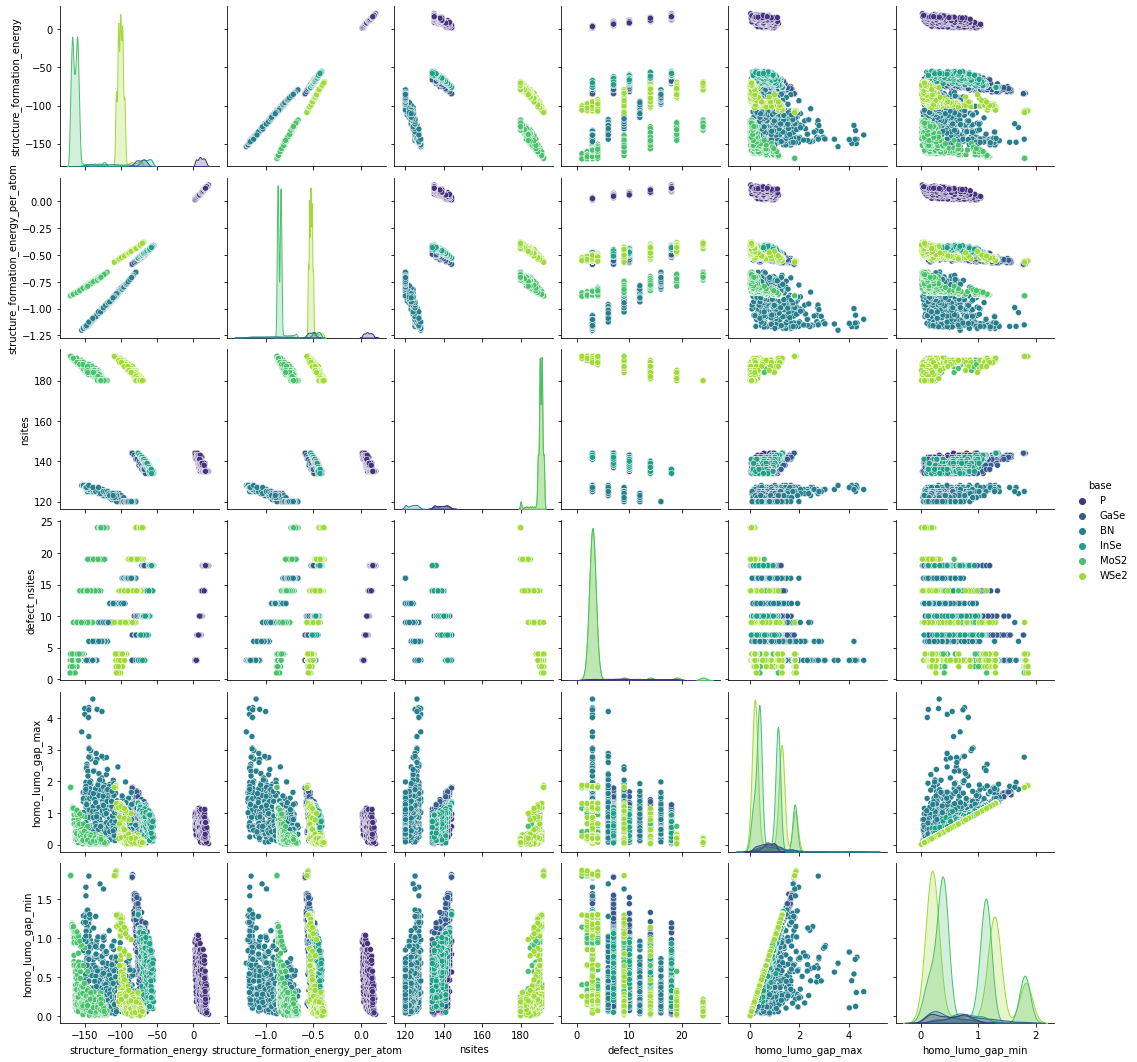

In [40]:
sns.pairplot(full_dataset[['structure_formation_energy',
                           'structure_formation_energy_per_atom',
                           'nsites', 'defect_nsites', 
                           'homo_lumo_gap_max', 'homo_lumo_gap_min',
                           'base']], 
                         hue='base', palette='viridis')

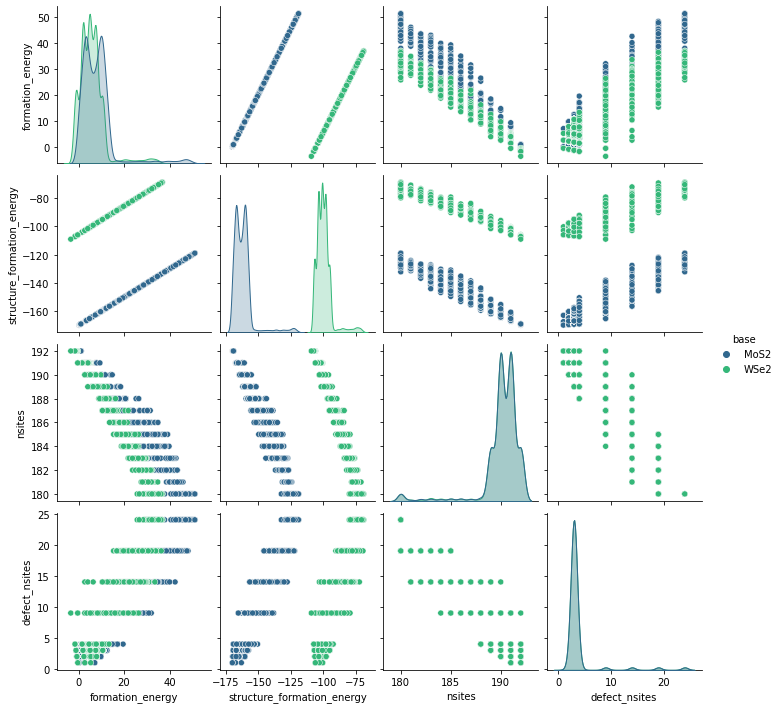

In [41]:
sub_data = full_dataset[(full_dataset['base'] == 'WSe2') | (full_dataset['base'] == 'MoS2')]
sns.pairplot(sub_data[['formation_energy', 'structure_formation_energy',
                       'nsites', 'defect_nsites', 'base']], 
             hue='base', palette='viridis')

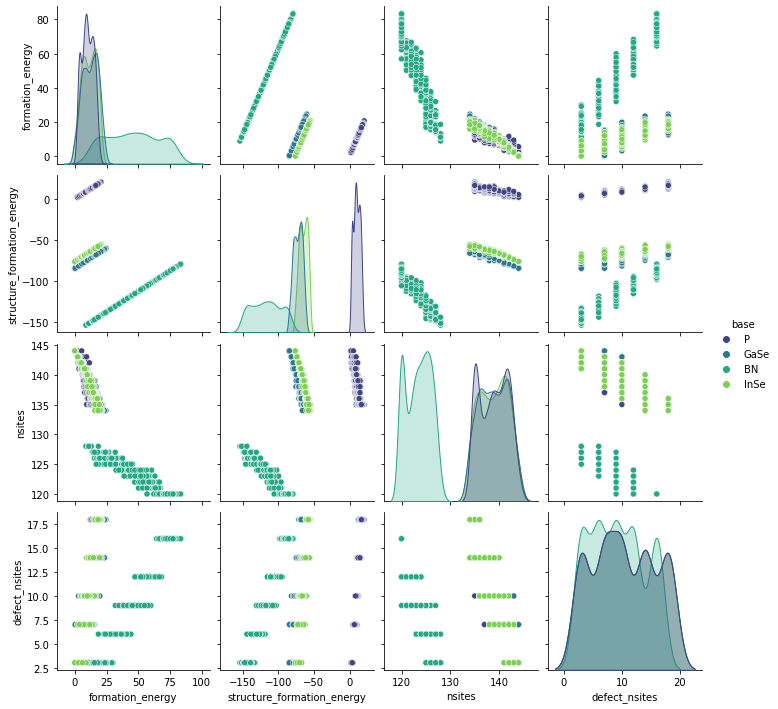

In [42]:
sub_data = full_dataset[(full_dataset['base'] != 'WSe2') & (full_dataset['base'] != 'MoS2')]
sns.pairplot(sub_data[['formation_energy', 'structure_formation_energy',
                       'nsites', 'defect_nsites', 'base']], 
             hue='base', palette='viridis')

### defects vs symmetry
statistics for the WSe2 and MoS2 base materials comprising both low and high defect content

In [45]:
full_dataset[full_dataset['base']=='WSe2'].groupby(['defect_nsites','space_group_no']).size()

defect_nsites  space_group_no
1              156                  2
               187                  2
2              1                   50
               5                    6
               6                    2
               8                   60
               39                   2
               156                  5
               187                  2
3              1                 5054
               5                  112
               6                   28
               8                  574
               38                  28
               156                  2
               187                  4
4              1                   98
               6                    1
               8                    1
9              1                  100
14             1                  100
19             1                  100
24             1                  100
dtype: int64

In [46]:
full_dataset[full_dataset['base']=='MoS2'].groupby(['defect_nsites','space_group_no']).size()

defect_nsites  space_group_no
1              156                  2
               187                  2
2              1                   50
               5                    6
               6                    2
               8                   60
               39                   2
               156                  5
               187                  2
3              1                 5054
               5                  112
               6                   28
               8                  574
               38                  28
               156                  2
               187                  4
4              1                   98
               8                    2
9              1                  100
14             1                  100
19             1                  100
24             1                  100
dtype: int64

### target analysis
visual and numerical analysis of target (thermodynamic) properties

/Users/Eremin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


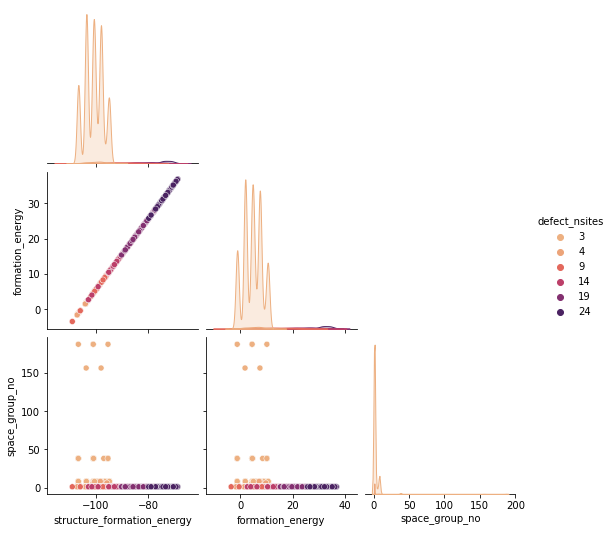

/Users/Eremin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


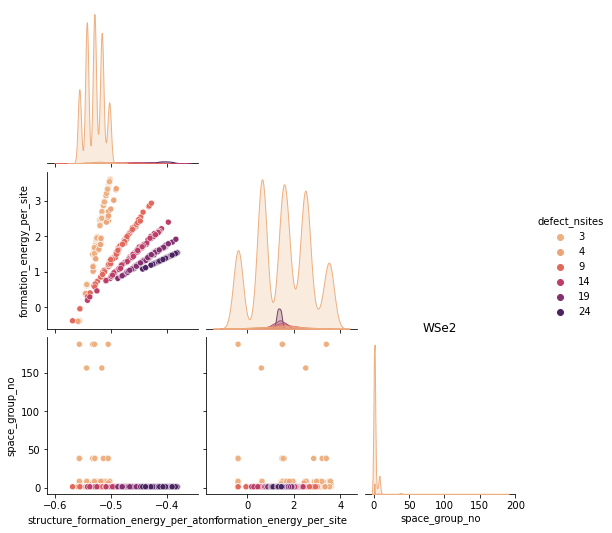

/Users/Eremin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


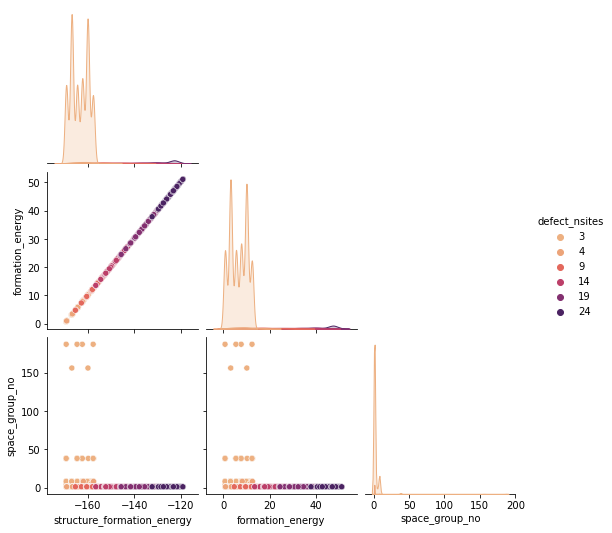

/Users/Eremin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


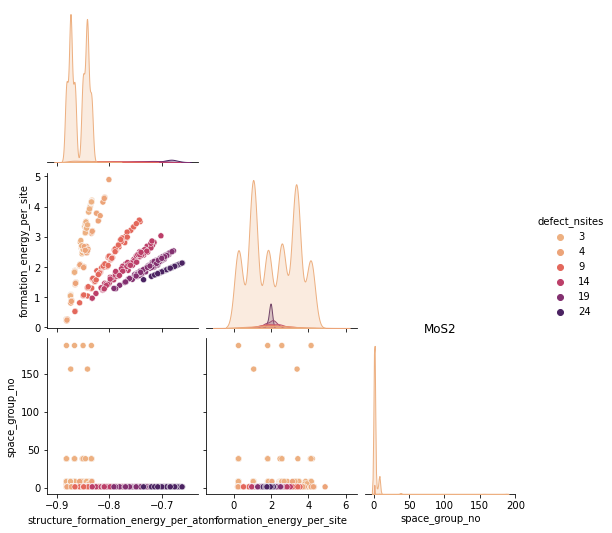

In [49]:
for base in ['WSe2', 'MoS2'] :
    sub_data = full_dataset[(full_dataset['base'] == base) & (full_dataset['defect_nsites'] >= 3)]
    sns.pairplot(sub_data[['structure_formation_energy', 'formation_energy', 
                           'space_group_no','defect_nsites']],
                 hue='defect_nsites', palette='flare', corner=True)
    # plt.title(base)
    plt.show()
    sub_data = full_dataset[(full_dataset['base'] == base) & (full_dataset['defect_nsites'] >= 3)]
    sns.pairplot(sub_data[['structure_formation_energy_per_atom', 'formation_energy_per_site',
                           'space_group_no','defect_nsites']],
                 hue='defect_nsites', palette='flare', corner=True)
    plt.title(base)
    plt.show()
    

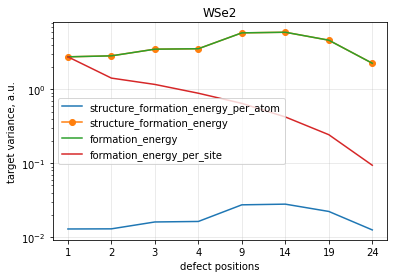

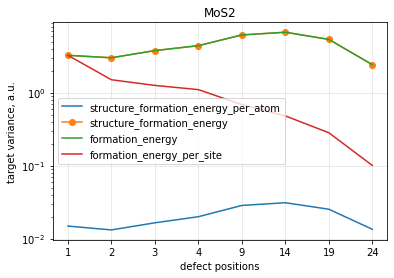

In [50]:
for base in ['WSe2', 'MoS2'] :
    result = []
    targets_to_analize = ['structure_formation_energy_per_atom', 'structure_formation_energy', 
                          'formation_energy', 'formation_energy_per_site', ]
    defect_contents = sorted(full_dataset[full_dataset['base'] == base]['defect_nsites'].unique())
    for defect_ns in defect_contents :
        subset = full_dataset[(full_dataset['base'] == base) & \
                                      (full_dataset['defect_nsites'] == defect_ns)][targets_to_analize]
        result += [[subset[target].std() for target in targets_to_analize]]

    result = np.array(result)
    result = result.T

    for i in range(result.shape[0]) :
        if i == 1 :
            plt.plot(result[i],  'o-',  label=targets_to_analize[i],)
        else :
            plt.plot(result[i], label=targets_to_analize[i])
    plt.grid(alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.xlabel('defect positions')
    plt.ylabel('target variance, a.u.')
    plt.title(base)
    plt.xticks(range(len(defect_contents)), list(map(str, defect_contents)))
    plt.show()

### Sample input for Graph Neural Networks (Allegro)
the code example below is a way to prepare data for training, validating and testing a graph neural network.

train_val_high
 defect_nsites  space_group_no
1              156                 2
               187                 2
2              8                  60
               39                  2
               156                 5
               187                 2
3              8                 574
               38                 28
               156                 2
               187                 4
dtype: int64

test0
 defect_nsites  space_group_no
2              1                   2
3              1                 194
               5                   4
dtype: int64
test1
 defect_nsites  space_group_no
4              1                 98
               8                  2
dtype: int64
test2
 defect_nsites  space_group_no
24             1                 100
dtype: int64
(400, 58)
new_test.shape (250, 58)
0
0
0
50
50
0
test3
 defect_nsites  space_group_no
4              1                 49
               8                  1
9              1                 50
14    

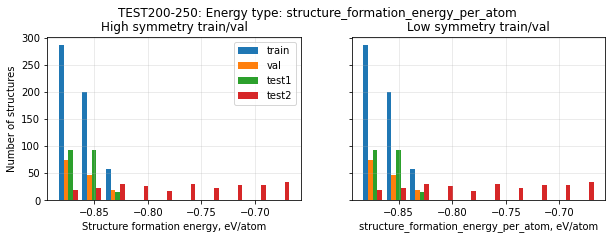

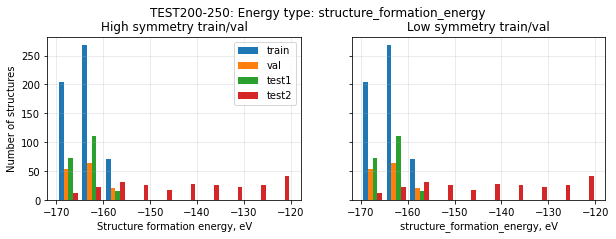

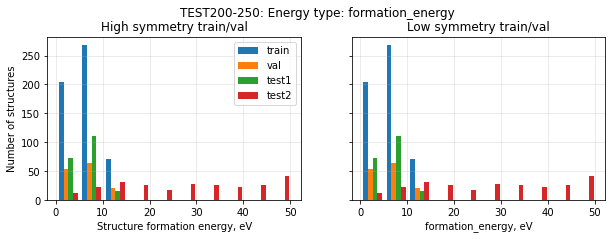

In [15]:
from sklearn.model_selection import train_test_split

base = 'MoS2'
base_dataset = full_dataset[full_dataset['base'] == base].copy()
high_sym_base = base_dataset[(base_dataset['defect_nsites'] < 4) & \
                                     (base_dataset['space_group_no'] >= 8)].copy()

print('train_val_high\n', high_sym_base.groupby(['defect_nsites', 'space_group_no']).size())
train, val = train_test_split(high_sym_base, test_size=0.2, shuffle=True, 
                              stratify=high_sym_base['defect_nsites'], random_state=0)
train.to_pickle(f'for_allegro/{base}_high_sym_train.pkl.gz')
val.to_pickle(f'for_allegro/{base}_high_sym_val.pkl.gz')
print()

low_sym_base = base_dataset[(base_dataset['defect_nsites'] < 4) & \
                            (base_dataset['space_group_no'] < 8)].copy()

_, test0 = train_test_split(low_sym_base, test_size=200, shuffle=True, 
                              stratify=low_sym_base['defect_nsites'], random_state=0)
print('test0\n', test0.groupby(['defect_nsites', 'space_group_no']).size())

## Prepare additional test in low and high defects contents

test1 = base_dataset[(base_dataset['defect_nsites'] == 4)]
print('test1\n', test1.groupby(['defect_nsites', 'space_group_no']).size())
test2 = base_dataset[(base_dataset['defect_nsites'] == 24)]
print('test2\n', test2.groupby(['defect_nsites', 'space_group_no']).size())
test = pd.concat((test0, test1, test2), axis=0)
test.to_pickle(f'for_allegro/{base}_test.pkl.gz')
print(test.shape)


train_val_low = low_sym_base[~np.isin(low_sym_base.index, test.index)].copy()

## USE NEW_TEST INSTEAD test 1-2

if base == 'WSe2' :
    new_test = pd.read_pickle(f'wse2_with_new_test/2d-materials-point-defects-all-table.pkl.gz')
    new_test = new_test[new_test['sample'] == 'test']
else :
    high_def_cont = base_dataset[base_dataset['defect_nsites'] >= 4].copy()
    _, new_test = train_test_split(high_def_cont, test_size=0.5, shuffle=True, 
                              stratify=high_def_cont['defect_nsites'], random_state=0)

# new_test = pd.read_pickle(f'wse2_with_new_test/2d-materials-point-defects-all-table.pkl.gz')
# sub = new_test[new_test['base'] == 'WSe2'].copy()
# new_test_mask = (sub['sample'] == 'test').values
# new_test = base_dataset[new_test_mask].copy()

print('new_test.shape', new_test.shape)

for previous_data_sample in [train, val, test0, test1, test2, train_val_low,] :
    print(sum(np.isin(new_test.index, previous_data_sample.index.values)))
    
test3 = base_dataset.loc[new_test.index]
#print(test1[np.isin(test1.index, new_test.index)].groupby('defect_nsites').size())
print('test3\n', test3.groupby(['defect_nsites', 'space_group_no']).size())

test_200_250 = pd.concat((test0, test3), axis=0)
test_200_250.to_pickle(f'for_allegro/{base}_test_200-250.pkl.gz')


print(test_200_250.shape)

print()

train_val_low = train_val_low.sample(n=high_sym_base.shape[0], random_state=0)

print('train_val_low\n', train_val_low.groupby(['defect_nsites', 'space_group_no']).size())
train_low, val_low = train_test_split(train_val_low, test_size=0.2, shuffle=True, 
                              stratify=high_sym_base['defect_nsites'], random_state=0)
train_low.to_pickle(f'for_allegro/{base}_low_sym_train.pkl.gz')
val_low.to_pickle(f'for_allegro/{base}_low_sym_val.pkl.gz')


# for energy_type in ['structure_formation_energy_per_atom', 'structure_formation_energy'] :
#     per_atom_addon = '/atom' if energy_type.endswith('_per_atom') else ''
#     fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3))
#     plt.suptitle(f'TEST200-200: Energy type: {energy_type}', y=1.02)
    
#     axs[0].hist([data[energy_type] for data in [train, val, 
#                                                 test.iloc[:200], test.iloc[200:]
#                                                ]], label=['train', 'val', 'test1', 'test2'])
#     axs[0].set_xlabel(f'Structure formation energy, eV{per_atom_addon}')
#     axs[0].set_ylabel('Number of structures')
#     axs[0].legend()
#     axs[0].grid(alpha=0.3)
#     axs[0].set_title('High symmetry train/val')

#     axs[1].hist([data[energy_type] for data in [train_low, val_low, test.iloc[:200], test.iloc[200:]]])
#     axs[1].set_xlabel(f'Structure formation energy, eV{per_atom_addon}')
#     axs[1].grid(alpha=0.3)
#     axs[1].set_title('Low symmetry train/val')

#     plt.show()
    
for energy_type in ['structure_formation_energy_per_atom', 'structure_formation_energy',
                    'formation_energy'] :
    per_atom_addon = '/atom' if energy_type.endswith('_per_atom') else ''
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 3))
    plt.suptitle(f'TEST200-250: Energy type: {energy_type}', y=1.02)
    
    axs[0].hist([data[energy_type] for data in [train, val, 
                                                test_200_250.iloc[:200], test_200_250.iloc[200:]
                                               ]], label=['train', 'val', 'test1', 'test2'])
    axs[0].set_xlabel(f'Structure formation energy, eV{per_atom_addon}')
    axs[0].set_ylabel('Number of structures')
    axs[0].legend()
    axs[0].grid(alpha=0.3)
    axs[0].set_title('High symmetry train/val')

    axs[1].hist([data[energy_type] for data in [train, val, 
                                                test_200_250.iloc[:200], test_200_250.iloc[200:]
                                               ]])
    axs[1].set_xlabel(f'{energy_type}, eV{per_atom_addon}')
    axs[1].grid(alpha=0.3)
    axs[1].set_title('Low symmetry train/val')

    plt.show()

In [51]:
new_test = pd.read_pickle(f'wse2_with_new_test/2d-materials-point-defects-all-table.pkl.gz')
sub = new_test[new_test['base'] == 'WSe2'].copy()
(sub['sample'] == 'test').values

array([False, False, False, ..., False, False, False])

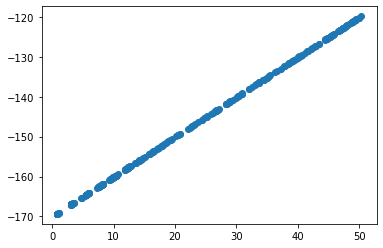

In [52]:
plt.scatter(test_200_250['formation_energy'], test_200_250['structure_formation_energy'],)
plt.show()

In [53]:
test_200_250.iloc[[0,-200, -1]][['ordinal_id', 'formation_energy', 'structure_formation_energy']]

,ordinal_id,formation_energy,structure_formation_energy
_id,,,
6142a2fa31cf3ef3d4a9f5bc,7002.0,10.042934,-160.089366
MoS2_Mo61W3Se3S122_0a438476-c874-40e0-854a-fb3fd915f860,8046.0,9.453755,-160.678545
MoS2_Mo57W3Se5S116_ca23f7e4-4dfe-47d3-ac26-0626216fe102,8324.0,42.237021,-127.895279


In [54]:
def allegroInput(dataset_file) :
    
    print(f'Allegro input generation for {dataset_file}')
    data = pd.read_pickle(dataset_file)
    dataset_xyz = re.sub('pkl.gz', 'xyz', dataset_file)
    with open(dataset_xyz, 'w') as out :
        for index in tqdm(data.index) :
            item = data.loc[index]
            lattice = item['lattice']
            atomic_symbols = item['atomic_symbols']
            positions = item['atomic_positions']
            fe = item['structure_formation_energy']
            fe_pa = item['structure_formation_energy_per_atom']
            fe_ori = item['formation_energy']
            ordinal_id = item['ordinal_id']

            out.write(f'{item.nsites}\n')
            out.write('Lattice=\"'+' '.join(list(map(str, list((lattice).reshape(-1,)))))+'\" ')
            out.write('Properties=species:S:1:pos:R:3 pbc=\"T T F\"  ') 
            out.write(f'ordinal_id={ordinal_id} \
                        structure_formation_energy={fe} \
                        structure_formation_energy_per_atom={fe_pa} \
                        original_formation_energy={fe_ori}')        
            out.write('\n')
            for symbol, pos in zip(atomic_symbols, positions) :
                out.write(symbol + '   ' + ' '.join(list(map(str, pos)))+'\n')

In [55]:
base_dataset[['formation_energy', 'structure_formation_energy']].describe()

,formation_energy,structure_formation_energy
count,6433.000000,6433.000000
mean,8.145590,-161.986710
std,7.929132,7.929132
min,0.166689,-169.965611
25%,3.137880,-166.994420
50%,7.701303,-162.430997
75%,10.068539,-160.063761
max,51.232735,-118.899565


In [56]:
for target_name in ['structure_formation_energy','formation_energy']:
    print(target_name, base_dataset[target_name].max() - base_dataset[target_name].min())


structure_formation_energy 51.06604660999999
formation_energy 51.06604661000006


In [57]:
from scipy.stats import pearsonr
pearsonr(base_dataset['formation_energy'], base_dataset['structure_formation_energy'])

PearsonRResult(statistic=1.0, pvalue=0.0)

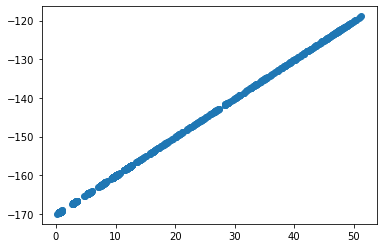

In [58]:
plt.scatter(base_dataset['formation_energy'], base_dataset['structure_formation_energy'])

In [59]:
def mixTrainVal(train1, train2, val1, val2, mix12=0.5, random_state=0) :
    assert train1.shape[0] == train2.shape[0]
    train_shape1 = int(round(train1.shape[0] * mix12))
    train_shape2 = train2.shape[0] - train_shape1
    
    assert val1.shape[0] == val2.shape[0]
    val_shape1 = int(round(val1.shape[0] * mix12))
    val_shape2 = val2.shape[0] - val_shape1
    
    result_train = pd.concat((train1.sample(train_shape1), train2.sample(train_shape2)), axis=0)
    result_val = pd.concat((val1.sample(val_shape1), val2.sample(val_shape2)), axis=0)
    
    return result_train, result_val

In [61]:
sg_analysis = pd.read_pickle('../Dataset_Aflow/rs_issue/rs_issue_for_symmetry_MoS2_do_not_use_WSe2/rs0/MoS2_0.25_high_sym_val_rs0.pkl.gz')
sum(sg_analysis['space_group_no'] >= 8) /sg_analysis['space_group_no'].shape[0]

0.24817518248175183

In [63]:
test_200_250[test_200_250['defect_nsites'] < 4 ].groupby(['defect_nsites', 'space_group_no']).size()

defect_nsites  space_group_no
2              1                   2
3              1                 194
               5                   4
dtype: int64

In [12]:
train_val_low.shape

(681, 45)